# Using 21cmFAST to Simulate the Epoch of Reionization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np

Matplotlib is building the font cache; this may take a moment.


## Knowing your Way Around

### Importing

The first thing to know is how to import `21cmFAST` and where everything lives. Import like this:

In [2]:
import py21cmfast as p21c

/users/smurray/miniconda3/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:49: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/users/smurray/miniconda3/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:32: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Like anything in the Jupyter notebook, you can explore what functions and modules are in the library by using tab complete:

In [ ]:
p21c.

And you can get help on a function by typing it then a SHIFT+TAB:

In [3]:
p21c.run_coeval

<function py21cmfast.wrapper.run_coeval(*, redshift=None, user_params=None, cosmo_params=None, astro_params=None, flag_options=None, regenerate=None, write=None, direc=None, init_box=None, perturb=None, use_interp_perturb_field=False, pt_halos=None, random_seed=None, cleanup=True, **global_kwargs)>

The difficult thing is to know where to start, and what all those parameters really mean! This tutorial will help with that a bit, but there's always the full documentation: https://21cmfast.readthedocs.io, and in particular, the beginner tutorials: https://21cmfast.readthedocs.io/en/latest/tutorials.html.

### An Overview of the Code Layout

Simulating a region of the universe that's millions of lightyears in size is not your every-day task. We do it by dealing with a "cube" of the universe which is a snapshot at a particular time, called a "coeval cube". The cube is split up into a large number of "voxels". This means the simulation doesn't know anything about scales larger than the box size, or smaller than the voxel size. The more voxels there are, the slower the computation goes, and the more computer memory it takes. It is _very hard_ to simulate a box both big enough to capture the large scale structure we care about, but also have small enough voxels to capture, say, individual galaxies. Often, each of these "smallest bits" of our simulation is large enough to contain tens of galaxies. 

Python is a great language, but it's not particularly well-suited to computations as big as this -- it's not especially fast or memory-efficient. So `21cmFAST` is mostly written in C, which is well-suited to this task. 

`21cmFAST` is built around a bunch of fast C functions which do most of the work, and then a Python _wrapper_, which helps you to get the input parameter combinations right, allows you to get the calculated simulation in a nice format so that it can be visualized, and provides a bunch of other nice things like caching your data, and saving it in nice formats. 

You will interact only with Python, but it's good to know that in the background some more hardcore calculations are being done. Every now and then, if something goes wrong, this will poke its head up with some kind of strange error. It's also the reason you had to install a bunch of C libraries when installing `21cmFAST`.

`21cmFAST` uses either four or five main _stages_, which we'll go through (and we saw on the slides). Each of them takes a number of parameters, and provides an input to the next stage. Each stage is by default written out to your hard-drive when you run it, and the next time you try to run exactly the same thing, `21cmFAST` will just go and grab it, rather than re-doing the calculation.

### Parameters

Most parameters that affect the physical simulation are broken up into groups that affect different parts of the calculation. There are four main groups, and an extra group that's a bit special.

To get a feel for how the parameters work, let's take a look at one of these groups, the cosmological parameters. These parameters set the overall expansion rate of the universe, and how much dark matter fills it, and how 'lumpy' it is. Take a look:

In [ ]:
p21c.CosmoParams (shift-tab)

We can create a set of parameters, where each one has a default (but we can set them to whatever we like):

In [4]:
cosmo_params = p21c.CosmoParams(
    OMm=0.35,
    SIGMA_8=0.81
)

Inside this set of parameters, we have access to a few methods from `astropy` that calculate useful quantities, eg.

In [5]:
cosmo_params.cosmo.comoving_distance(z=3)

<Quantity 6269.97542046 Mpc>

In [6]:
cosmo_params.cosmo.age(z=0)

<Quantity 13.3183643 Gyr>

You can see what all the default parameters are for a given group of parameters by doing this:

In [7]:
p21c.CosmoParams._defaults_

{'SIGMA_8': 0.8102,
 'hlittle': 0.6766,
 'OMm': 0.30964144154550644,
 'OMb': 0.04897468161869667,
 'POWER_INDEX': 0.9665}

You can also change a parameter after we've created the object:

In [8]:
cosmo_params.update(SIGMA_8=0.8, hlittle=0.7)

If you print the object you get a full description of it:

In [9]:
print(cosmo_params)

CosmoParams(OMb:0.04897468161869667, OMm:0.35, POWER_INDEX:0.9665, SIGMA_8:0.8, hlittle:0.7)


The "special" set of parameters I mentioned are the _global_ parameters. If you change one of these, it changes everywhere, so you need to be careful with it. We won't use it (at least not explicitly) in this tutorial. There are a lot of parameters in there, but they're ones that don't usually need to be changed unless you really know what you're doing.

In [14]:
p21c.global_params?

If you _do_ need to change one of these, the best way to do it is like this:

In [11]:
with p21c.global_params.use(ZPRIME_STEP_FACTOR=1.05):
    print(p21c.global_params.ZPRIME_STEP_FACTOR)
    # do some other stuff
    
# then back here it's been set back to the default
print(p21c.global_params.ZPRIME_STEP_FACTOR)

1.05
1.0199999809265137


## Initial Conditions

The first step is to compute the dark matter distribution. We need to kinds of parameters to do this -- a set that tells the simulator how big to make the box and some other options like that, and a set of cosmological parameters.

We've already set up our cosmological parameters (you can change them if you want!), let's set up our "user params":

In [12]:
p21c.UserParams._defaults_

{'BOX_LEN': 300.0,
 'DIM': None,
 'HII_DIM': 200,
 'USE_FFTW_WISDOM': False,
 'HMF': 1,
 'USE_RELATIVE_VELOCITIES': False,
 'POWER_SPECTRUM': 0,
 'N_THREADS': 1,
 'PERTURB_ON_HIGH_RES': False,
 'NO_RNG': False,
 'USE_INTERPOLATION_TABLES': False}

We're going to ignore most of these options, because they're more advanced than we need (and they have reasonable defaults). The important ones for us are the first three.

`BOX_LEN`: this is the size of the box, in Mpc (3.3 million light years!). We need to set this large enough to capture the scales we care about many times over. There might be other considerations, like if we're trying to simulate what HERA might observe, we can calculate the the size of the box required:

In [13]:
hera_field_of_view = 0.13  # radians
hera_field_of_view * cosmo_params.cosmo.comoving_transverse_distance(z=7)

<Quantity 1061.13826347 Mpc>

This is enormous! We're going to be a bit more modest today.

`DIM`: this is the number of cells along a side of the high-resolution initial conditions box, so that the total number of cells is `DIM^3`. `21cmFAST` suggests that you need a high enough `DIM` such that each voxel has a side length of well less than 1 Mpc, otherwise it can't do the physics it needs to  (remember, galaxies are much smaller than this, ~0.03 Mpc).

`HII_DIM`: This is the number of cells along a side for the boxes with values for hydrogen. `21cmFAST` really needs _high-resolution_ boxes only for the initial density field. It then smooths this down to a lower resolution to save memory, and this `HII_DIM` defines this resolution.

One thing to take into account is your RAM: the size in memory of each box (and there are multiple boxes) is `4 * DIM**3` bytes (or `HII_DIM`). So, for `DIM=1000`, that's 4 GB per box. On a supercomputer, this is fine. On your laptop that's not.

A few of the other options have to do with which models to use for some cosmological quantities: the `HMF` is the halo mass function, which defines how many halos there are of different masses -- we have a few different models for how this should look, but the default is a good one. The `POWER_SPECTRUM` defines the statistical spatial distribution of density lumps in the CMB. We have a few ways of calculating that, ranging from simple to very involved, but again, the default is fine here.

So let's create our user params:

In [16]:
user_params = p21c.UserParams(
    BOX_LEN=200,
    DIM=400,
    HII_DIM=150,
    USE_INTERPOLATION_TABLES=True
)

To perform our first step, and get the initial conditions, we use the function `initial_conditions`:

In [17]:
init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params, 
    user_params=user_params
)

`init_cond` is what we call an `OutputStruct` -- essentially its an object that wraps around results calculated by C, and provides some extra nice methods to look at them.

In [18]:
type(init_cond), isinstance(init_cond, p21c._utils.OutputStruct)

(py21cmfast.outputs.InitialConditions, True)

Every `OutputStruct` has an attribute called `fields` which can help you find the output data:

In [19]:
init_cond.fieldnames

['lowres_density',
 'lowres_vx',
 'lowres_vy',
 'lowres_vz',
 'lowres_vx_2LPT',
 'lowres_vy_2LPT',
 'lowres_vz_2LPT',
 'hires_density',
 'hires_vx',
 'hires_vy',
 'hires_vz',
 'hires_vx_2LPT',
 'hires_vy_2LPT',
 'hires_vz_2LPT',
 'lowres_vcb',
 'hires_vcb']

These are all `numpy` arrays, and we can get their shape and size:

In [20]:
total_size = 0
for name in init_cond.fieldnames:
    obj = getattr(init_cond, name)
    print(f"{name} has shape {obj.shape} and size {4 * obj.size / 1024 / 1024:0.2f} MB")
    total_size += 4 * obj.size / 1024 / 1024 / 1024
    
print(f"Total Size: {total_size:.2f} GB")

lowres_density has shape (150, 150, 150) and size 12.87 MB
lowres_vx has shape (150, 150, 150) and size 12.87 MB
lowres_vy has shape (150, 150, 150) and size 12.87 MB
lowres_vz has shape (150, 150, 150) and size 12.87 MB
lowres_vx_2LPT has shape (150, 150, 150) and size 12.87 MB
lowres_vy_2LPT has shape (150, 150, 150) and size 12.87 MB
lowres_vz_2LPT has shape (150, 150, 150) and size 12.87 MB
hires_density has shape (400, 400, 400) and size 244.14 MB
hires_vx has shape (400, 400, 400) and size 244.14 MB
hires_vy has shape (400, 400, 400) and size 244.14 MB
hires_vz has shape (400, 400, 400) and size 244.14 MB
hires_vx_2LPT has shape (400, 400, 400) and size 244.14 MB
hires_vy_2LPT has shape (400, 400, 400) and size 244.14 MB
hires_vz_2LPT has shape (400, 400, 400) and size 244.14 MB
lowres_vcb has shape (150, 150, 150) and size 12.87 MB
hires_vcb has shape (400, 400, 400) and size 244.14 MB
Total Size: 2.01 GB


We can also make plots of them:

**BREAKOUT CHALLENGE**
Use matplotlib to create an image of a slice of the high-res density cube. Try adding a title and axis labels, and a colorbar!

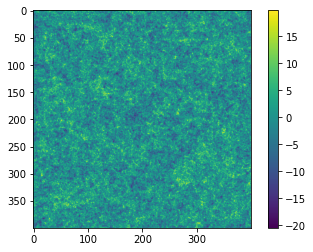

In [21]:
plt.imshow(init_cond.hires_density[0, :, :])
plt.colorbar()

While you can make the plot yourself, it is a little easier to use `21cmFAST` to make the plot:

Text(0.5, 1.0, 'Dark Matter Overdensity at z=0')

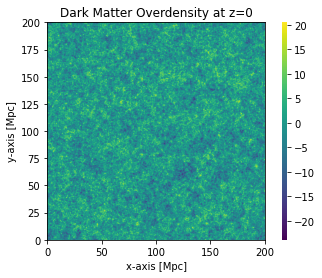

In [22]:
p21c.plotting.coeval_sliceplot(init_cond, kind='hires_density')
plt.title("Dark Matter Overdensity at z=0")

We can also make a plot of the velocity field:

Text(0.5, 1.0, 'Dark Matter Velocity (x) at z=0')

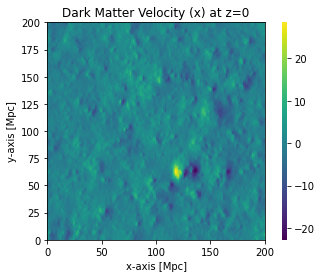

In [23]:
p21c.plotting.coeval_sliceplot(init_cond, kind='lowres_vx_2LPT')
plt.title("Dark Matter Velocity (x) at z=0")

## Evolving the Field

We care not about redshift of zero (our own time!) but redshifts of 6 and higher. Let's take a look at a redshift that HERA is trying to probe -- z=8:

In [20]:
perturbed = p21c.perturb_field(
    redshift=8.0,
    init_boxes=init_cond   # Note we don't have to pass cosmo/user params!
)

**BREAKOUT CHALLENGE**
Use the `21cmFAST` plotting routines to make plots of 'density' and 'velocity'. What are the differences between this and the initial conditions?

Text(0.5, 1.0, 'Density')

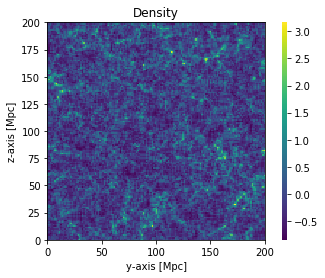

In [22]:
p21c.plotting.coeval_sliceplot(perturbed, slice_axis=0)
plt.title("Density")

Text(0.5, 1.0, 'Velocity (in z-direction)')

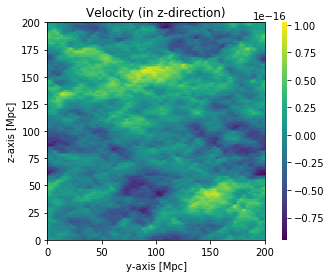

In [23]:
p21c.plotting.coeval_sliceplot(perturbed, 'velocity', slice_axis=0)
plt.title("Velocity (in z-direction)")

## Ionizing Hydrogen

Now, we can assume that wherever there's dark matter, there's also hydrogen, probably with a roughly fixed ratio. But how much of that hydrogen is neutral (i.e. has the electron that allows it to emit at 21cm)? Roughly, very early on, we expect most hydrogen to be neutral, but as the universe evolves, galaxies are going to cause some of the hydrogen to ionize.

There are a bunch more options we require at this point, telling `21cmFAST` what kinds of galaxies existed when (and how bright they were) and how easy it was for radiation at the right frequency to escape galaxies into the hydrogen in the inter-galactic medium:

In [24]:
p21c.AstroParams._defaults_

{'HII_EFF_FACTOR': 30.0,
 'F_STAR10': -1.3,
 'F_STAR7_MINI': -2.0,
 'ALPHA_STAR': 0.5,
 'F_ESC10': -1.0,
 'F_ESC7_MINI': -2.0,
 'ALPHA_ESC': -0.5,
 'M_TURN': 8.7,
 'R_BUBBLE_MAX': None,
 'ION_Tvir_MIN': 4.69897,
 'L_X': 40.0,
 'L_X_MINI': 40.0,
 'NU_X_THRESH': 500.0,
 'X_RAY_SPEC_INDEX': 1.0,
 'X_RAY_Tvir_MIN': None,
 'F_H2_SHIELD': 0.0,
 't_STAR': 0.5,
 'N_RSD_STEPS': 20}

We won't discuss all these parameters in detail. `HII_EFF_FACTOR` scales the efficiency with which galaxies emit ionizing photons into the IGM, all the "star" parameters concern the brightness of galaxies given how much dark matter is in a given place, while the "esc" quantities define what fraction of ionizing radiation escapes the galaxies. `ION_TVIR_MIN` defines the smallest dark matter clumps (called halos) that can host galaxies capable of ionizing hydrogen. By default, all of these parameters are about as good a guess as we could want. Feel free to change them, but usually not by more than a factor of about 2.

The last kinds of parameters are those that turn different features on and off. By default, all features are turned off, and you can switch them on if you want. Beware that most features mean more computation time:

In [25]:
p21c.FlagOptions._defaults_

{'USE_HALO_FIELD': False,
 'USE_MINI_HALOS': False,
 'USE_MASS_DEPENDENT_ZETA': False,
 'SUBCELL_RSD': False,
 'INHOMO_RECO': False,
 'USE_TS_FLUCT': False,
 'M_MIN_in_Mass': False,
 'PHOTON_CONS': False,
 'USE_INTERPOLATION_TABLES': False}

One of the more interesting ones here is `USE_TS_FLUCT`: with this off, we don't take into account the heating of the hydrogen. That is, if the hydrogen is being excited, but not enough to ionize, then it will have more atoms in the excited state and ready to emit. It turns out that if the temperature of the hydrogen is high enough, then the actual emission rate doesn't depend strongly on how hot it is anymore, and we can ignore it. This is true for most models at some redshifts. We're going to ignore it now because it takes *a lot* longer to calculate.


Here's how to call the function to simulate the ionization state throughout the box. Note two things: one is that we're not actually giving it the perturbed field we created already. That's OK, because it will automatically go find it on your hard drive, since it uses the same parameters. The reason we're doing that here is because we want you to calculate this ionization box at lots of different redshifts, which clearly can't use the same perturbed field.

The other thing to note is that we're defining the astro params here as a _dictionary_, rather than defining the full `AstroParams` object. `21cmFAST` knows what to do with this. 

In [63]:
ionized = p21c.ionize_box(
    redshift=8.0, 
    init_boxes=init_cond, 
    astro_params={'HII_EFF_FACTOR': 25.0}
)

Let's have a look at what's been calculated:

In [64]:
type(ionized)

py21cmfast.outputs.IonizedBox

In [33]:
ionized.fieldnames

['first_box',
 'mean_f_coll',
 'mean_f_coll_MINI',
 'log10_Mturnover_ave',
 'log10_Mturnover_MINI_ave',
 'xH_box',
 'Gamma12_box',
 'z_re_box',
 'dNrec_box',
 'temp_kinetic_all_gas',
 'Fcoll',
 'Fcoll_MINI']

These are all physical quantities that are required to obtain the ionization state, except `xH_box`, which is the ionization state itself: the neutral fraction.

**BREAKOUT CHALLENGE**

Use a `for loop` and the `ionize_box` function to calculate the ionization box at z=[20, 12, 10, 9, 8, 7, 6, 5], and plot the `xH_box` field from that structure. Don't keep the output around - just use to it make the plots!
Use the `simple_xH_plot` function below to make your plot. We've add some of the code you'll need to help you along the way.

**Note:** feel free to change up the `AstroParams` a bit! Let's see what different parameters do!



In [74]:
def simple_xH_plot(ion: p21c.outputs.IonizedBox, ax: plt.Axes):
    return ax.imshow(ion.xH_box[:, :, 0].T, extent=(0,200,0,200), vmin=0, vmax=1, origin='lower')

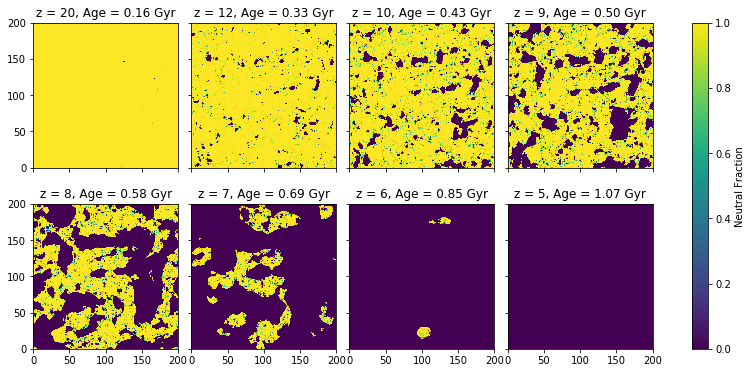

In [75]:
fig, ax = plt.subplots(2, 4, figsize=(14,6), sharex=True, sharey=True, gridspec_kw={"hspace":0.25, 'wspace': 0.05})

for i, z in enumerate([20, 12, 10, 9, 8, 7, 6, 5]):
    ion = p21c.ionize_box(redshift=z, init_boxes=init_cond)
    im = simple_xH_plot(ion, ax.flatten()[i])
    ax.flatten()[i].set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}")
    
cbar = plt.colorbar(im, ax=ax.ravel().tolist())
cbar.set_label("Neutral Fraction")

## Brightness Temperature

The final step is to use the distribution of neutral hydrogen to compute what signal _we would see today_ in comparison to the background CMB. We need no further parameters to do this, we just need to call a final function:

In [68]:
brightness_temp = p21c.brightness_temperature(
    ionized_box=ionized,
    perturbed_field=perturbed,
)

Let's make a plot!

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f65387e7950>)

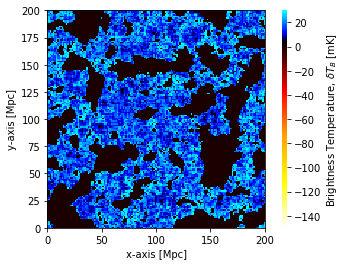

In [69]:
p21c.plotting.coeval_sliceplot(brightness_temp)

Notice that `coeval_sliceplot` plots a _default_ field from the object. It also knows about some things you want to plot, and how to plot them more nicely. 

Also notice that the basic pattern here is very similar to the $z=8$ map of the neutral fraction. In particular, where there's no neutral hydrogen, there's no brightness temperature.

## The Simple Way

We've gone through all the steps to get our brightness temperature, but `21cmFAST` actually has an easier way, which we saw right at the start. Since you almost always want to do all the steps one after the other, you can just run `run_coeval` to do them all:

In [76]:
coeval = p21c.run_coeval(
    redshift=8.0,
    cosmo_params = cosmo_params,
    user_params = user_params,
)

The `Coeval` object has _everything_ we want in it -- the initial conditions, the perturb field, the ionization state, and the brightness temperature:

In [78]:
coeval.

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6537e29c50>)

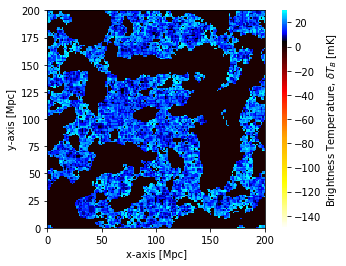

In [79]:
p21c.plotting.coeval_sliceplot(coeval)

You can also directly save the whole `Coeval` cube anywhere you want, to read it in later, or send to a colleague:

In [81]:
coeval.save('my_coeval.h5')

'/home/steven/Documents/TutesAndLectures/Programming/CHAMP_Bootcamp/Lesson9_Reionization_and_21cmFAST/my_coeval.h5'

## LightCones

Above, we produced a bunch of outputs at different redshifts to see how the Universe evolves over time.
Recall that redshift corresponds to frequency of 21cm emission, and that a telescope like HERA observes many frequencies all at once (50 - 250 MHz). Often we'll want to simulate what the telescope might see, rather than individual cubes at one redshift. 

The telescope can really only see a single 2D slice at any particular redshift. Looking into the line of sight not only sees different parts of space, but also different times. 

`21cmFAST` has a reasonably smart function for producing these "light cones", which have one dimension that evolves in both space and time. 

Let's get a lightcone that might look a little like one that HERA would see (we're going to shorten it a bit to make it fit in memory more easily for this tutorial):

In [90]:
with p21c.global_params.use(ZPRIME_STEP_FACTOR=1.1):
    lightcone = p21c.run_lightcone(
        redshift = 1420./200.0 - 1,
        max_redshift = 1420./100.0 - 1,
        init_box=init_cond,
        lightcone_quantities=(
            'brightness_temp',
            'xH_box',
            'density'
        ),
        global_quantities=(
            'brightness_temp',
            'xH_box'
        )
    )

There's also a nice convenience function for plotting the lightcone:

(<Figure size 1321.2x342 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f64bf87e610>)

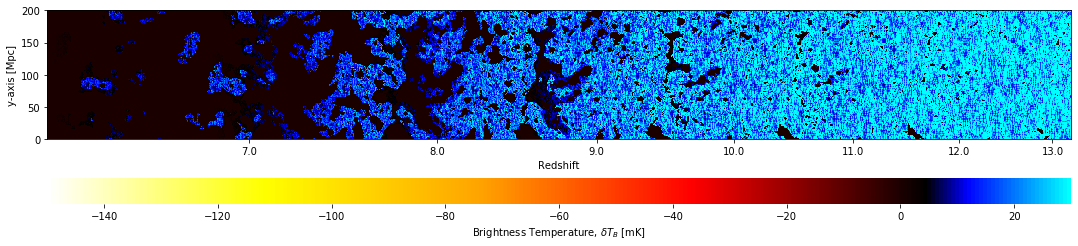

In [91]:
p21c.plotting.lightcone_sliceplot(lightcone)

The `Lightcone` object has a number of useful methods and attributes. All the quantities we asked to save are in there. So we could also have asked to plot the `xH_box`:

(<Figure size 1321.2x342 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f64bf7b5090>)

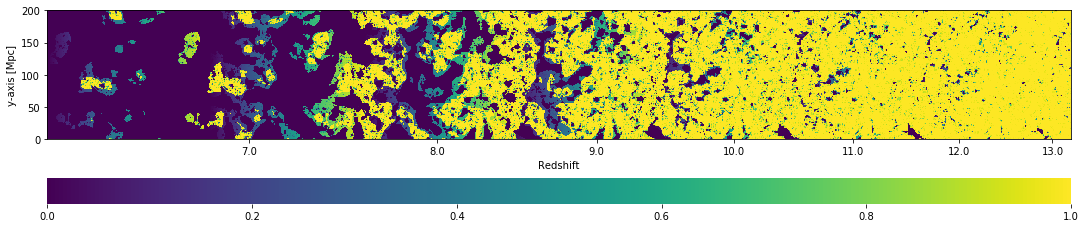

In [92]:
p21c.plotting.lightcone_sliceplot(lightcone, kind='xH_box')

Here you can see that the edges of the ionized bubbles you get cells that have _some_ hydrogen ionized, and then islands of fully neutral hydrogen.

Let's have a look at this compared to the underlying dark matter density:

(<Figure size 1321.2x342 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f64bf79ccd0>)

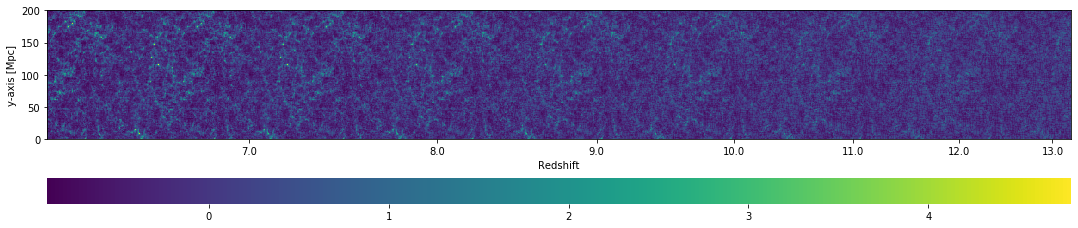

In [93]:
p21c.plotting.lightcone_sliceplot(lightcone, kind='density')

Notice how the high overdensities, which tend to host galaxies, are associated with ionized regions. 

We can also plot "global" quantities, which is the average of the quantity over the whole "sky" at a particular redshift:

(<Figure size 288x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6537e78090>)

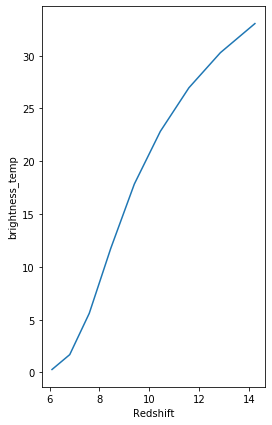

In [97]:
p21c.plotting.plot_global_history(lightcone)

**BREAKOUT CHALLENGE**

The "midpoint" of reionization is defined as the redshift at which the global neutral fraction is 0.5. What is the midpoint of reionization from your simulation?